In [1]:
import jax
import chex
import einops
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import jax.numpy as jnp
import matplotlib.pyplot as plt

from io import StringIO
from typing import Callable
from functools import partial
from datetime import datetime

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 16

In [4]:
theta_values = -2, -1, 0, 3, 7,

## HMM Orstein-Uhlenbeck process

$$
    x_{t+\Delta}^\ell = \kappa(\theta_{t, \ell} - x_{t, \ell}) \Delta + \sigma\sqrt{\Delta} W_t
$$

with $W_t \sim \cal{N}(0, 1)$

In [5]:
transition_matrix = jnp.array([
    [0.00,  0.05, 0.05, 0.05, 0.05],
    [0.10,  00.0, 0.10, 0.05, 0.05],
    [0.10,  0.20, 0.00, 0.05, 0.05],
    [0.10,  0.20, 0.01, 0.00, 0.05],
    [0.10,  0.20, 0.20, 0.20, 0.00],
])

p_stay = 1 - transition_matrix.sum(axis=1)
transition_matrix = transition_matrix.at[jnp.diag_indices(5)].set(p_stay)

transition_matrix

Array([[0.8       , 0.05      , 0.05      , 0.05      , 0.05      ],
       [0.1       , 0.7       , 0.1       , 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.59999996, 0.05      , 0.05      ],
       [0.1       , 0.2       , 0.01      , 0.64      , 0.05      ],
       [0.1       , 0.2       , 0.2       , 0.2       , 0.3       ]],      dtype=float32)

## Loading datset

In [762]:
date_init = datetime.timestamp(datetime(2000, 1, 1))
date_end = datetime.timestamp(datetime(2023, 12, 8))

config = {
    "events": "history",
    "period1": str(int(date_init)),
    "period2": str(int(date_end)),
    "includeAdjustedClose": "true"
}

assets = ["JPM", "AAPL", "NVDA", "SHEL", "WMT", "KO", "HD", "BRK-B"]

datasets = {}
for asset in assets:
    url = f"https://query1.finance.yahoo.com/v7/finance/download/{asset}"
    r = requests.get(
        url,
        headers={'User-agent': 'Mozilla/5.0'},
        params=config
    )

    data = pd.read_csv(StringIO(r.text))
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.set_index("Date")

    series = data["Adj Close"]
    series.name = asset
    datasets[asset] = series
datasets = pd.DataFrame.from_dict(datasets)

In [855]:
returns = np.log1p(datasets.pct_change(1)).dropna() # log(1 + x); x = (S1 / S0 - 1); log(1 + S1 / S0 - 1) = log(S1 / S0)
returns = jnp.array(returns.to_numpy())
n_steps, _ = returns.shape
timesteps = np.arange(n_steps)

In [764]:
sns.set_palette("Set2", len(assets))

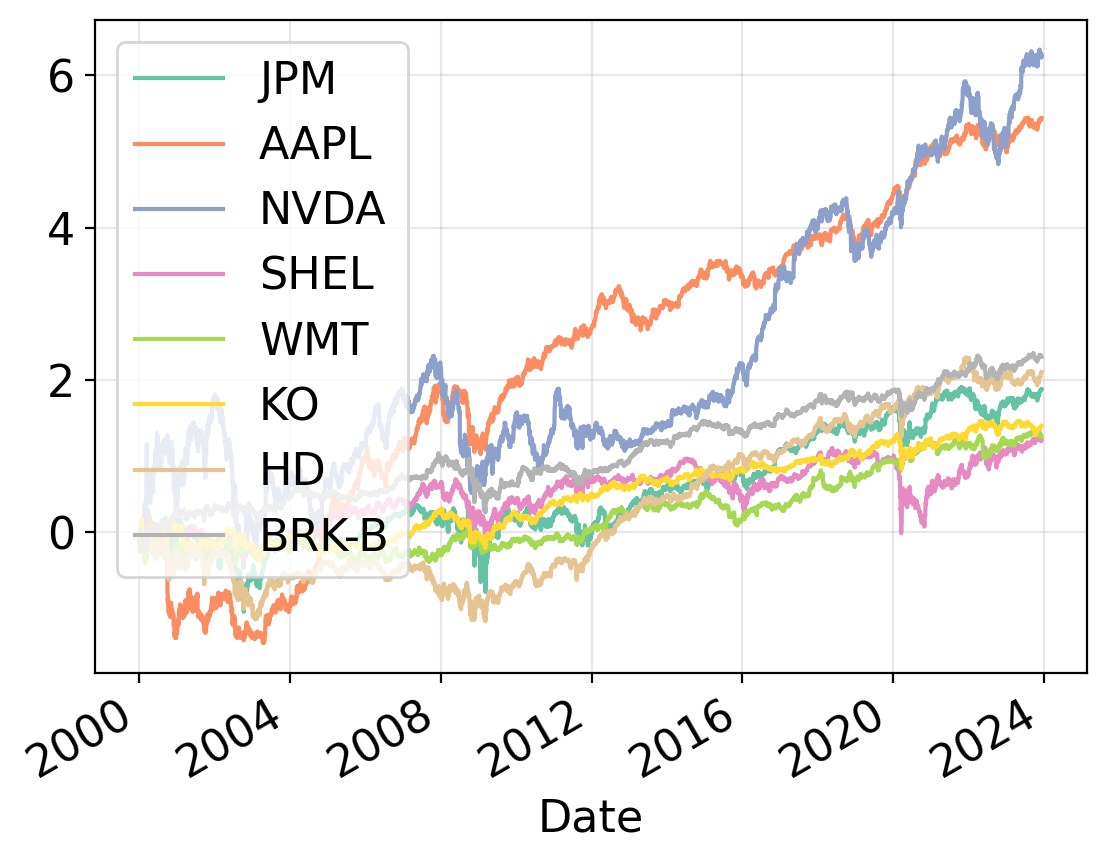

In [765]:
datasets_logr = pd.DataFrame(np.array(returns), index=datasets.index[1:], columns=assets)
index_date = datasets_logr.index
(datasets_logr.cumsum()).plot()
plt.grid(alpha=0.3)
plt.savefig("../figures/bandits-log-cumreturn.pdf")

# Stationary $\epsilon$-greedy bandit

In [766]:
import jfin

def store_reward(state, action, reward):
    return reward

def store_reward_action(state, action, reward):
    return reward, action

In [767]:
key = jax.random.PRNGKey(3141)
agent = jfin.EpsilonGreedyAgent(epsilon=0.5)
state_final, returns_bandit = agent.init_and_run(key, returns, store_reward)

In [768]:
sr_ann = returns_bandit.mean() / returns_bandit.std() * jnp.sqrt(252)
sr_ann

Array(0.400292, dtype=float32)

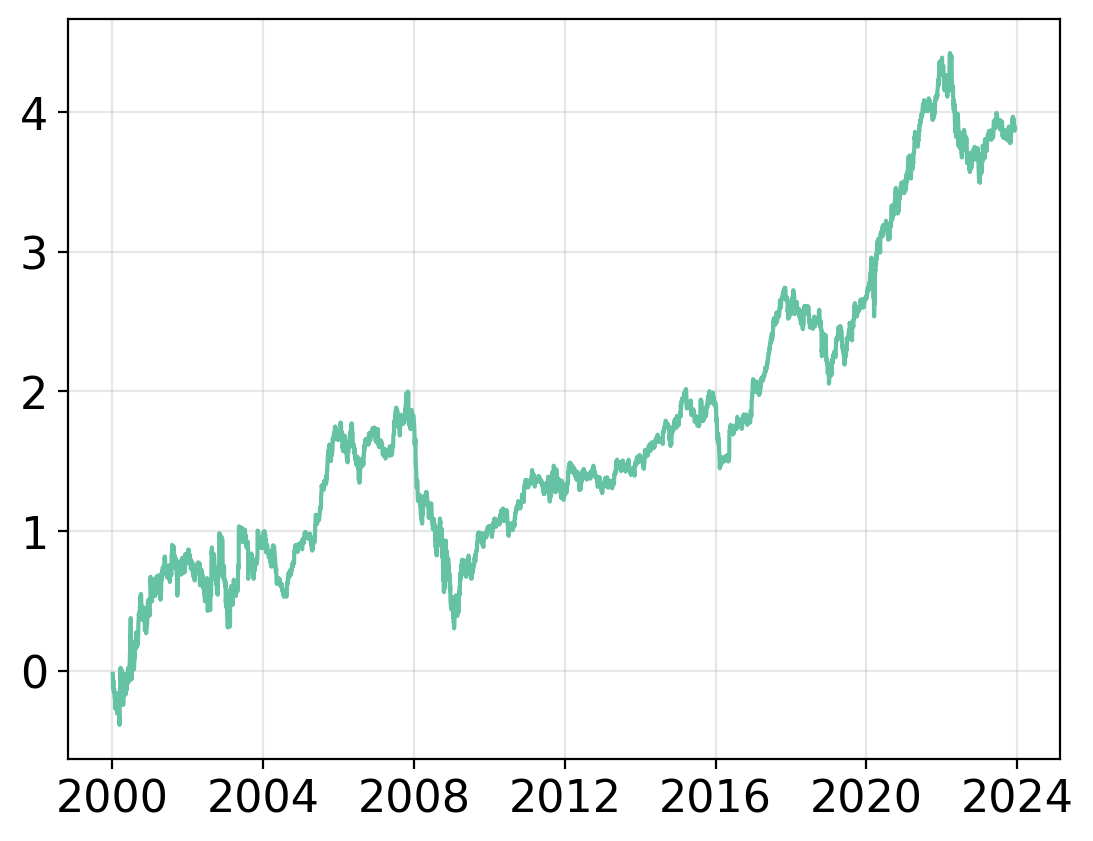

In [769]:
plt.plot(index_date, returns_bandit.cumsum())
plt.grid(alpha=0.3)

## Multiple simulations

Is this a winning strategy?

In [770]:
n_sims = 50
state_final, returns_bandit = agent.init_and_run_sims(key, returns, store_reward, n_sims)
returns_bandit.shape

(50, 6021)

In [771]:
sr_ann = returns_bandit.mean(axis=-1) / returns_bandit.std(axis=-1) * jnp.sqrt(252)
jnp.percentile(sr_ann, 50)

Array(0.38296014, dtype=float32)

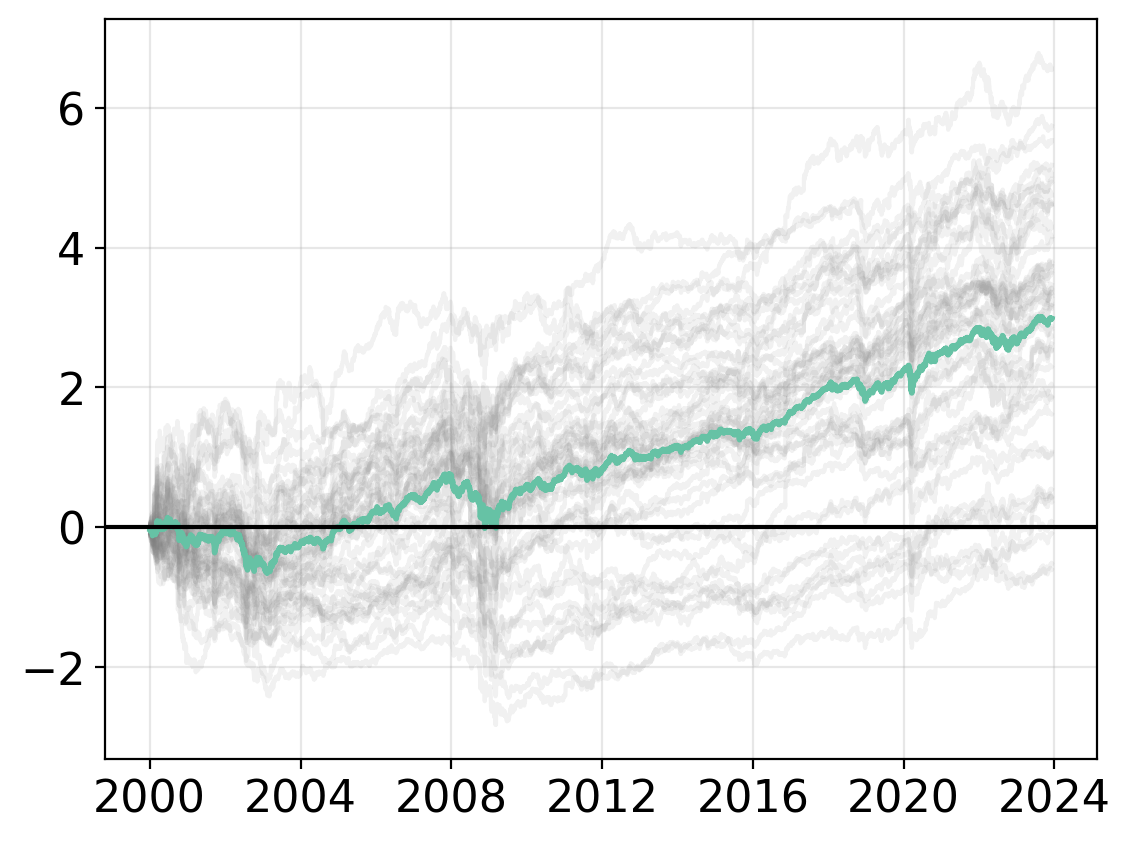

In [772]:
pnl_sims = np.array(returns_bandit.cumsum(axis=-1))
plt.plot(index_date, pnl_sims.T, alpha=0.1, c="tab:gray");
plt.plot(index_date, pnl_sims.mean(axis=0), linewidth=2)
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)

## Evaluating over multiple $\epsilon$ values

In [773]:
@partial(jax.vmap, in_axes=(0, 0, None, None))
def eval_epsilon(key, epsilon, data, n_sims):
    agent = jfin.EpsilonGreedyAgent(epsilon=epsilon)
    state_final, returns = agent.init_and_run_sims(key, data, store_reward, n_sims)
    res = {
        "pnl": returns.sum(axis=-1),
        "sr_ann": returns.mean(axis=-1) / returns.std(axis=-1) * np.sqrt(252),
        "epsilon": epsilon
    }
    
    return res

In [774]:
%%time
n_sims = 100
n_epsilon_values = 25
epsilon_values = jnp.linspace(0.01, 1, n_epsilon_values)

keys_epsilon = jax.random.split(key, n_epsilon_values)
res = eval_epsilon(keys_epsilon, epsilon_values, returns, n_sims)
res = jax.tree_map(np.array, res)

CPU times: user 2.05 s, sys: 26.5 ms, total: 2.08 s
Wall time: 10.9 s


### Sharpe ratio

In [775]:
returns_sr = pd.DataFrame(res["sr_ann"], index=epsilon_values).T

returns_sr_mean = returns_sr.mean()
returns_sr_mean.name = "mean_sr"

palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = returns_sr_mean.reset_index().sort_values("mean_sr", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

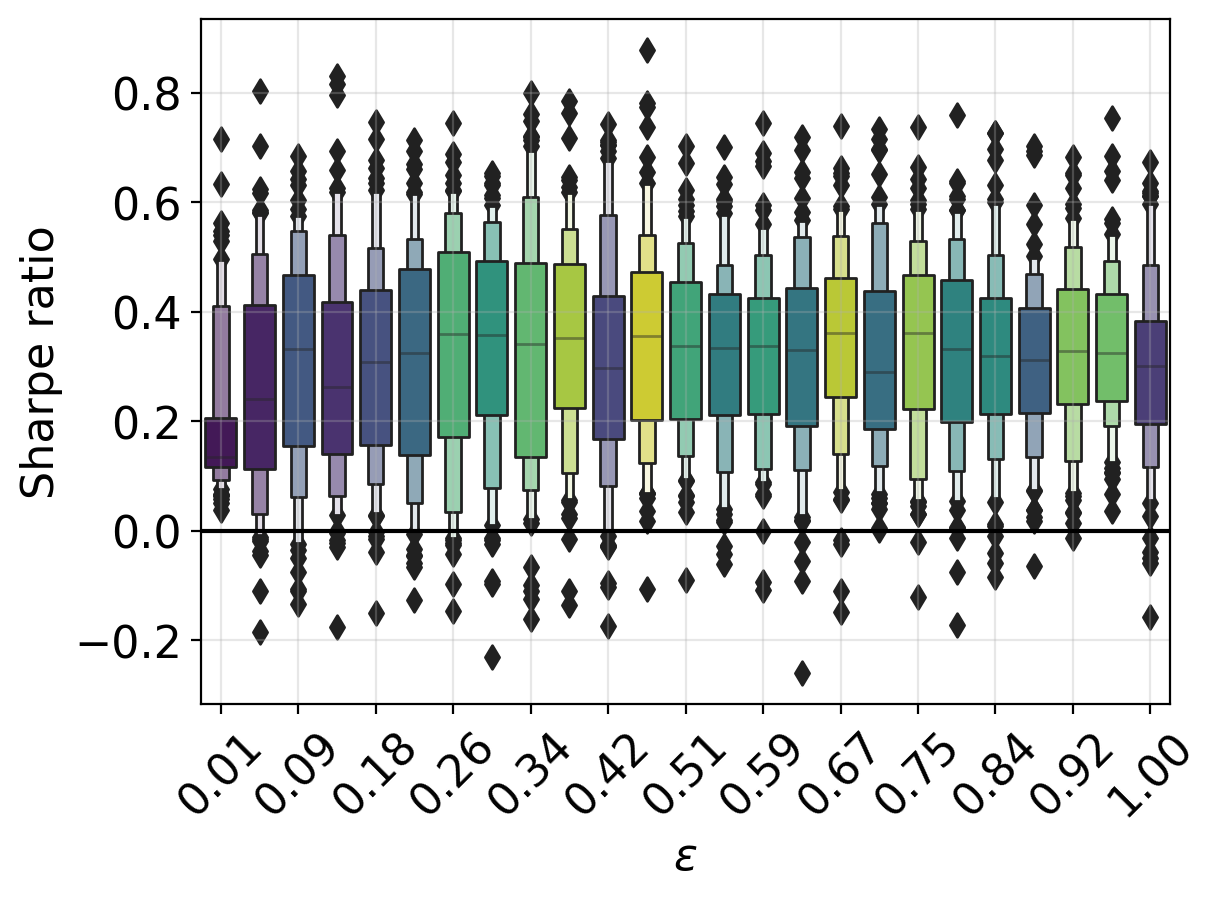

In [776]:
sns.boxenplot(
    x="variable",
    y="value",
    data=returns_sr.melt(),
    palette=colors,
    linewidth=1
)

plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("Sharpe ratio")
plt.axhline(y=0, c="black")
plt.tight_layout()
plt.savefig("../figures/stationary-bandit-mean-sr.pdf")

### PnL

In [777]:
returns_pnl = pd.DataFrame(res["pnl"], index=epsilon_values).T

returns_pnl_mean = returns_pnl.mean()
returns_pnl_mean.name = "pnl"

palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = returns_pnl_mean.reset_index().sort_values("pnl", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

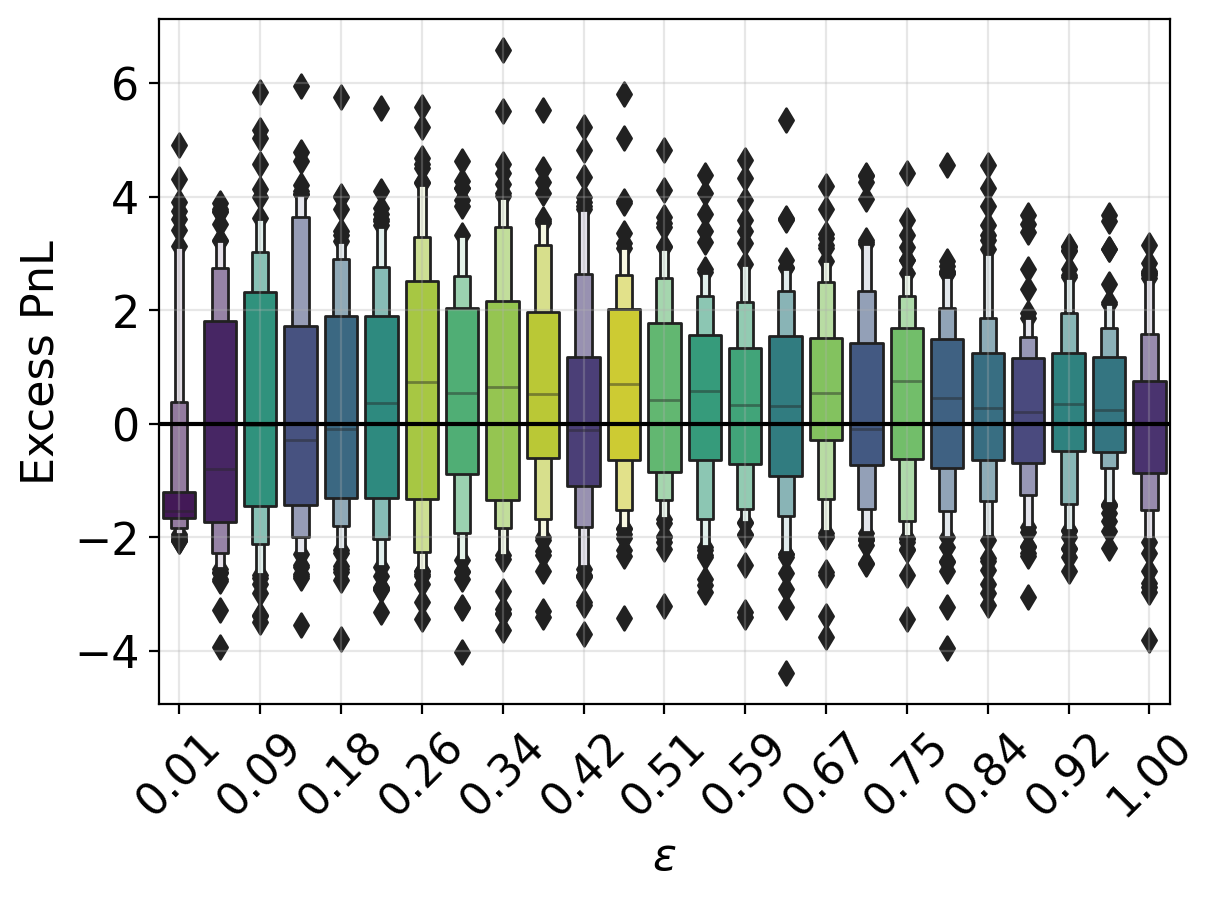

In [778]:
sns.boxenplot(
    x="variable",
    y="value",
    data=(returns_pnl - returns_pnl[1].mean()).melt(),
    palette=colors,
    linewidth=1
)

plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("Excess PnL")
plt.axhline(y=0, c="black")
plt.tight_layout()
plt.savefig("../figures/stationary-bandit-mean-sr.pdf")

# non-stationary $\epsilon$-greedy

## Evaluating over multiple $\epsilon$ values

In [779]:
@partial(jax.jit, static_argnames=("n_sims",))
@partial(jax.vmap, in_axes=(None, None, 0, None, None))
@partial(jax.vmap, in_axes=(None, 0, None, None, None))
def eval_epsilon_alpha(key, epsilon, alpha, data, n_sims):
    agent = jfin.EpsilonGreedyAgent(epsilon=epsilon, alpha=alpha)
    state_final, returns = agent.init_and_run_sims(key, data, store_reward, n_sims)
    res = {
        "pnl": returns.sum(axis=-1),
        "sr_ann": returns.mean(axis=-1) / returns.std(axis=-1) * np.sqrt(252),
        "epsilon": epsilon,
        "alpha": alpha
    }
    
    return res

In [780]:
%%time
n_sims = 100
n_epsilon_values = 15
n_alpha_values = 20
epsilon_values = jnp.linspace(0.01, 1, n_epsilon_values)
alpha_values = jnp.linspace(0.01, 1, n_alpha_values)

keys_epsilon = jax.random.split(key, n_epsilon_values)
res = eval_epsilon_alpha(key, epsilon_values, alpha_values, returns, n_sims)
res = jax.tree_map(np.array, res)

CPU times: user 3.2 s, sys: 97.2 ms, total: 3.3 s
Wall time: 2min 1s


In [781]:
sr_ann = pd.DataFrame(res["sr_ann"].mean(axis=-1), index=alpha_values, columns=epsilon_values)

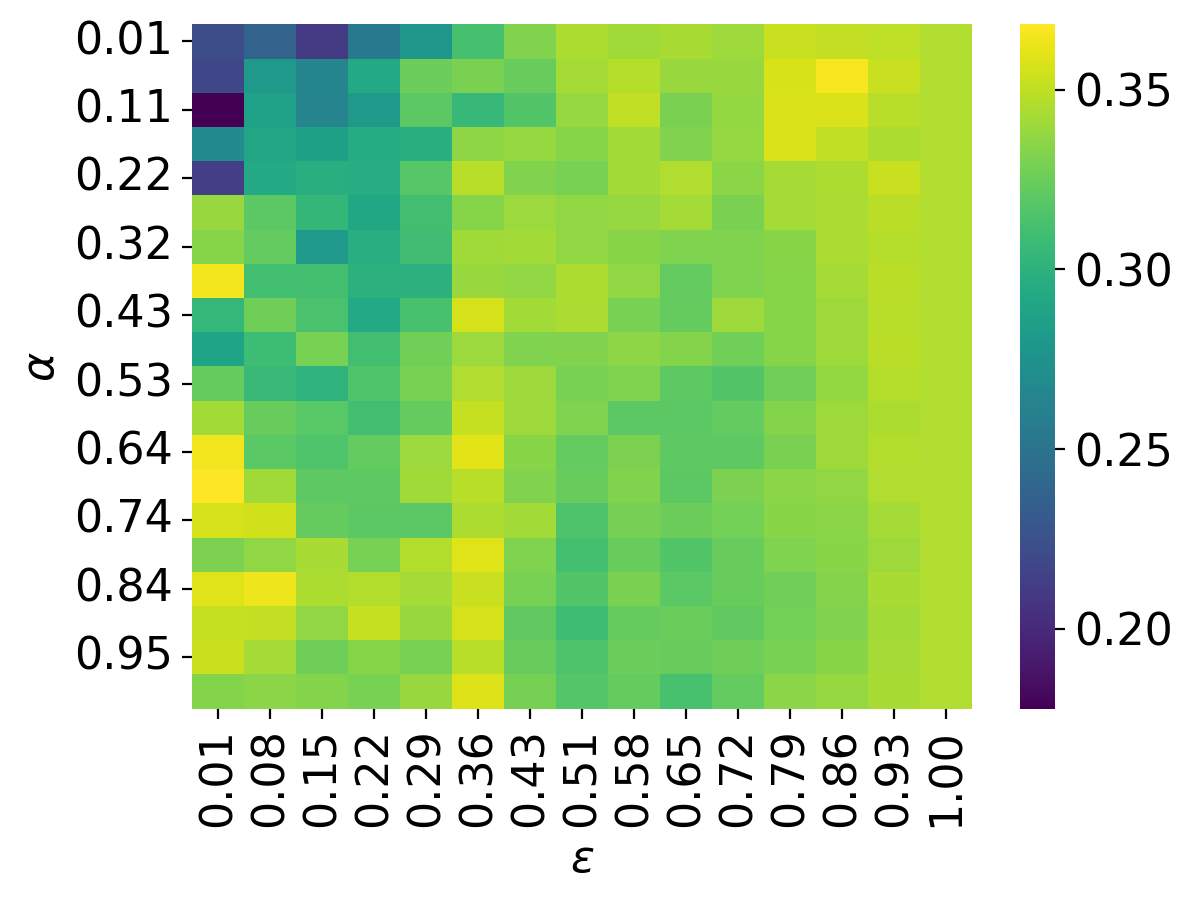

In [782]:
ax = sns.heatmap(sr_ann, cmap="viridis")
ax.invert_yaxis()

ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])
ax.set_xticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_xticklabels()])
ax.invert_yaxis()

plt.xlabel(r"$\epsilon$")
plt.ylabel(r"$\alpha$")
plt.tight_layout()
# plt.savefig("../figures/non-stationary-alpha-epsilon-grid-sr.pdf", dpi=300);

### PnL

In [783]:
returns_pnl = pd.DataFrame(res["pnl"][-5], index=epsilon_values).T

returns_pnl_mean = returns_pnl.mean()
returns_pnl_mean.name = "pnl"

palette = sns.color_palette("viridis_r", n_epsilon_values)

colors = returns_pnl_mean.reset_index().sort_values("pnl", ascending=False)
colors.index = sorted(colors.index)
colors = colors.reset_index()

colors["hue"] = colors.apply(lambda row: palette[int(row["level_0"])], axis=1)
colors = colors.sort_values("index")["hue"].to_list()

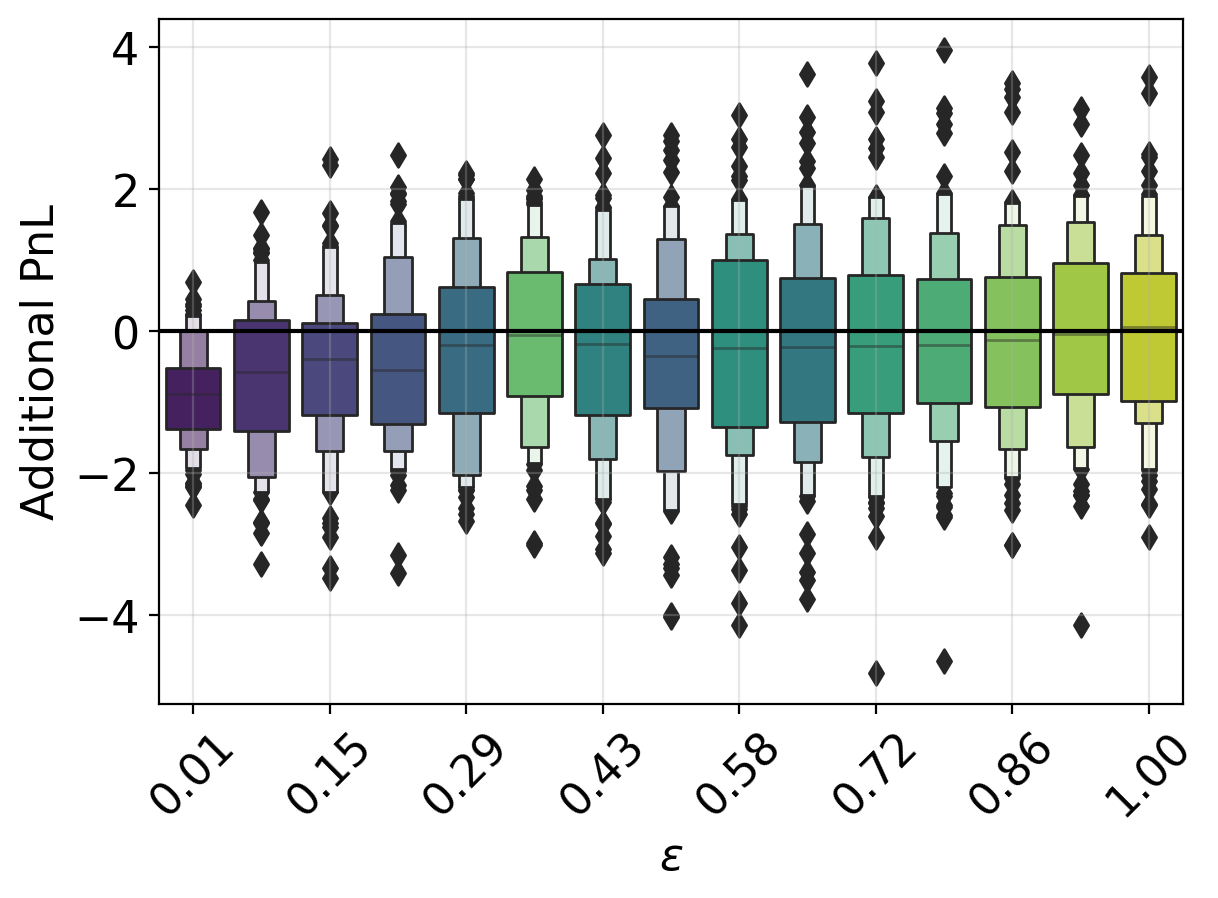

In [784]:
sns.boxenplot(
    x="variable",
    y="value",
    data=(returns_pnl - returns_pnl[1].mean()).melt(),
    palette=colors,
    linewidth=1
)

plt.grid(alpha=0.3)
values, ticks = plt.xticks()
ticks = [format(float(t.get_text()), "0.2f") for t in ticks]
plt.xticks(values[::2], ticks[::2], rotation=45)
plt.xlabel("$\epsilon$")
plt.ylabel("Additional PnL")
plt.axhline(y=0, c="black")
plt.tight_layout()
plt.savefig("../figures/non-stationary-bandit-mean-sr.pdf")

# Tabular Contextual bandits

In [917]:
returns = np.log1p(datasets.pct_change(1)).dropna() # log(1 + x); x = (S1 / S0 - 1); log(1 + S1 / S0 - 1) = log(S1 / S0)
returns = jnp.array(returns.to_numpy())
n_steps, _ = returns.shape
timesteps = np.arange(n_steps)

# returns = jnp.c_[returns, -returns]
# assets_extend = [*assets, *[f"{a}_short" for a in assets]]

In [918]:
context = (returns > 0) * 1
context.shape

(6021, 8)

In [919]:
sns.set_palette("Set2")

In [920]:
epsilon = 0.05
n_sims = 30

span = 28 
alpha = 2 / (span + 1)
alpha

agent = jfin.EpsilonGreedyAgent(epsilon=epsilon, alpha=alpha)
state, (rewards_nc) = agent.init_and_run_sims(key, returns[1:], store_reward, n_sims)
pnl_nc = rewards_nc.cumsum(axis=1)
pnl_nc_mid = np.percentile(pnl_nc, 50, axis=0)
pnl_nc_lbound = np.percentile(pnl_nc, 10, axis=0)
pnl_nc_ubound = np.percentile(pnl_nc, 90, axis=0)

agent = jfin.EpsilonGreedyAgent(epsilon=epsilon, alpha=0.0)
state, rewards_nc_stat = agent.init_and_run_sims(key, returns[1:], store_reward, n_sims)
pnl_nc_stat = rewards_nc_stat.cumsum(axis=1)
pnl_nc_stat_mid = np.percentile(pnl_nc_stat, 50, axis=0)
pnl_nc_stat_lbound = np.percentile(pnl_nc_stat, 10, axis=0)
pnl_nc_stat_ubound = np.percentile(pnl_nc_stat, 90, axis=0)

agent = jfin.TabularEpsilonGreedyAgent(epsilon=epsilon, alpha=alpha)
state, rewards = agent.init_and_run_sims(key, returns[1:], context[:-1], store_reward, n_sims)

pnl = rewards.cumsum(axis=1)
pnl_mid = np.percentile(pnl, 50, axis=0)
pnl_lbound = np.percentile(pnl, 10, axis=0)
pnl_ubound = np.percentile(pnl, 90, axis=0)

In [921]:
c0 = sns.color_palette()[0]
c1 = sns.color_palette()[1]
c2 = sns.color_palette()[2]

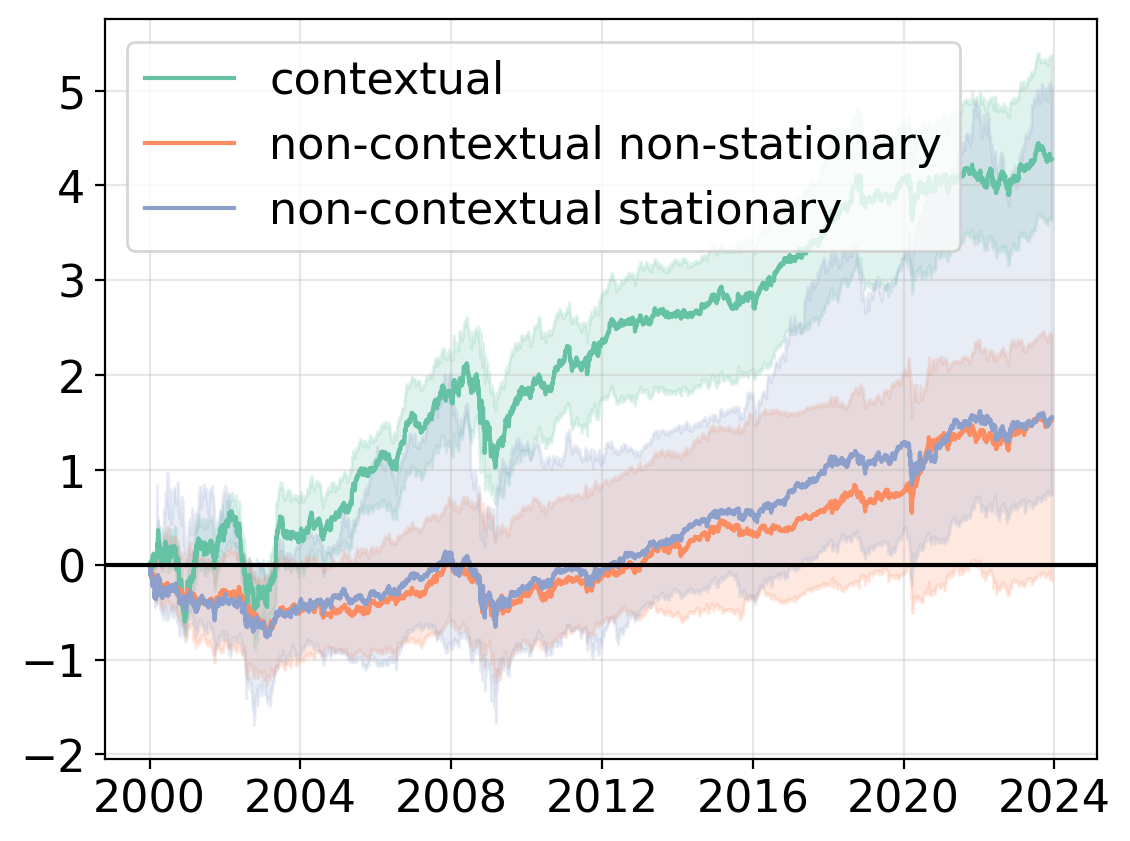

In [922]:
plt.plot(index_date[1:], pnl_mid, label="contextual")
plt.fill_between(index_date[1:], pnl_lbound, pnl_ubound, color=c0, alpha=0.2)

plt.plot(index_date[1:], pnl_nc_mid, label="non-contextual non-stationary", c=c1)
plt.fill_between(index_date[1:], pnl_nc_lbound, pnl_nc_ubound, color=c1, alpha=0.2)

plt.plot(index_date[1:], pnl_nc_stat_mid, label="non-contextual stationary", c=c2)
plt.fill_between(index_date[1:], pnl_nc_stat_lbound, pnl_nc_stat_ubound, color=c2, alpha=0.2)


plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.axhline(y=0, c="black")

In [923]:
sr_c = pd.Series(np.array(rewards.mean(axis=1) / rewards.std(axis=1) * np.sqrt(252)), name="contextual")
sr_nc = pd.Series(rewards_nc.mean(axis=1) / rewards_nc.std(axis=1) * np.sqrt(252), name="non-contextual")
sr_nc_stat = pd.Series(rewards_nc_stat.mean(axis=1) / rewards_nc_stat.std(axis=1) * np.sqrt(252), name="non-contextual stationary")

pd.concat([sr_c, sr_nc, sr_nc_stat], axis=1).describe()

,contextual,non-contextual,non-contextual stationary
count,30.000000,30.000000,30.000000
mean,0.510874,0.189404,0.268022
std,0.080239,0.146258,0.165788
min,0.333200,-0.138028,0.041838
25%,0.455600,0.124158,0.160518
50%,0.504884,0.234257,0.222381
75%,0.551983,0.258809,0.352340
max,0.662811,0.474388,0.721605


In [942]:
epsilon = 0.05
# epsilon = 0.1
agent = jfin.TabularEpsilonGreedyAgent(epsilon=epsilon, alpha=alpha)
state, (rewards, actions) = agent.init_and_run(key, returns[1:], context[:-1], store_reward_action)

In [925]:
agent = jfin.EpsilonGreedyAgent(epsilon=epsilon, alpha=alpha)
state, (rewards, actions) = agent.init_and_run(key, returns[1:], store_reward_action)

In [943]:
actions_ohe = jax.nn.one_hot(actions, len(assets))

In [944]:
v = pd.DataFrame(actions_ohe, index=datasets.index[2:]).rolling(252).mean()

In [945]:
sns.set_palette("Spectral", len(assets))
# sns.set_palette("Set2")
# sns.set_palette("husl", len(assets))

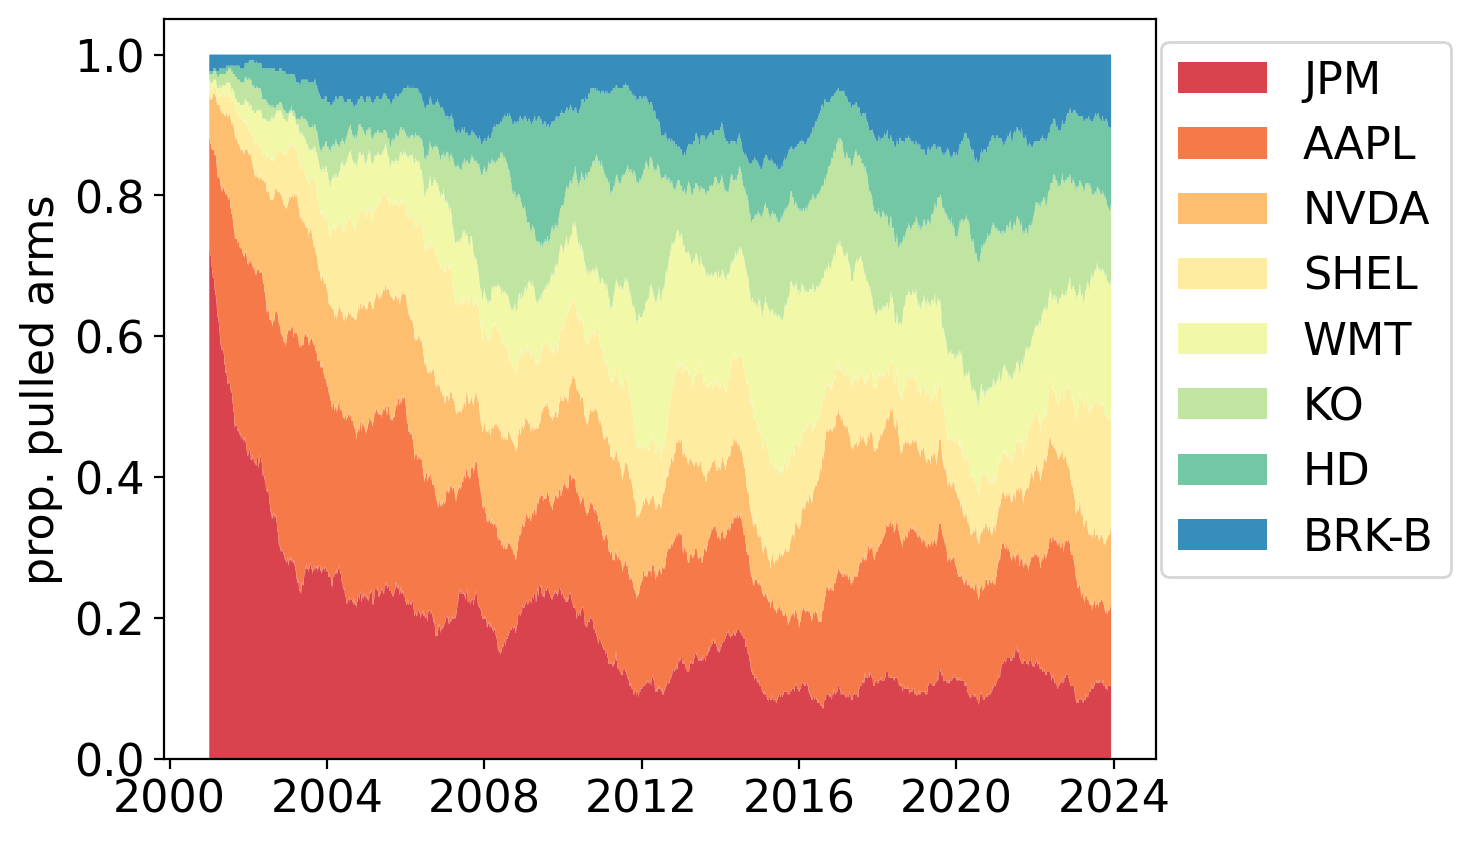

In [946]:
plt.stackplot(
    v.index,
    [v[i] for i in v],
    labels=assets,
)
plt.ylabel("prop. pulled arms")
plt.legend(bbox_to_anchor=(1.32, 1), loc="upper right");

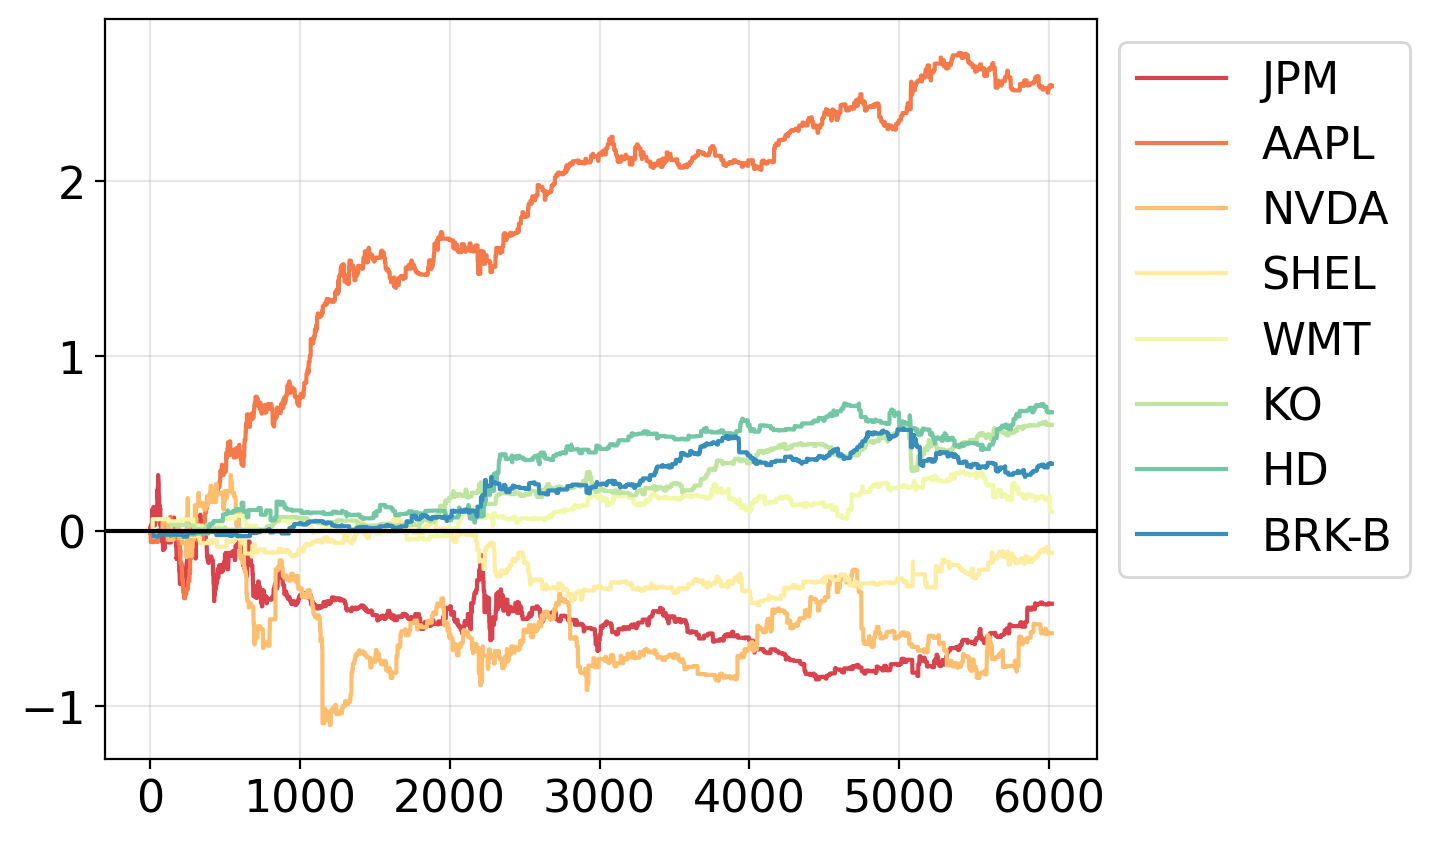

In [947]:
plt.plot((actions_ohe * returns[1:]).cumsum(axis=0), label=assets)
plt.legend(bbox_to_anchor=(1,1))
plt.axhline(y=0, c="black")
plt.grid(alpha=0.3)